In [13]:
from blackjackenv import BlackjackEnv
# load config
import gymnasium as gym
import neat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

config_file = './config-feedforward.txt'
env = BlackjackEnv(sab=True)


In [14]:
genome_rounds = 100

def eval_action(action):
    if action[0] > 0.5:
        return 1
    else:
        return 0

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0
        agent = neat.nn.FeedForwardNetwork.create(genome, config)
        
        for i in range(0, genome_rounds):
            state, info = env.reset()
            done = False
            hitMultiplier = 1
            
            while not done:
                agent_action = agent.activate(state)
                #round action to 0 or 1
                agent_action = eval_action(agent_action)
                
                #if agent did hit give a bonus to the reward
                if agent_action == 1:
                    hitMultiplier += 1
                
                next_state, reward, terminated, truncated, info = env.step(agent_action)
                
                # update if the environment is done and the current obs
                done = terminated or truncated
                state = next_state
                
                if(reward == 1):
                    genome.fitness += 1 * hitMultiplier
        
        #genome.fitness /= genome_rounds
        #print(f'Genome {genome_id} fitness: {genome.fitness}')

In [15]:
generations = 100
population = 50

# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
#p.add_reporter(neat.Checkpointer(5))

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=generations * population)

# Run the simulation
winner = p.run(eval_genomes, generations)

# show final stats
print('\nBest genome:\n{!s}'.format(winner))


 ****** Running generation 0 ****** 
Population's average fitness: 23.78000 stdev: 19.29071
Best fitness: 53.00000 - size: (1, 3) - species 1 - id 29
Average adjusted fitness: 0.449
Mean genetic distance 1.110, standard deviation 0.356
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50     53.0    0.449     0
Total extinctions: 0
Generation time: 1.915 sec

 ****** Running generation 1 ****** 
Population's average fitness: 29.92000 stdev: 17.26017
Best fitness: 61.00000 - size: (1, 3) - species 1 - id 29
Average adjusted fitness: 0.490
Mean genetic distance 1.114, standard deviation 0.419
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50     61.0    0.490     0
Total extinctions: 0
Generation time: 1.549 sec (1.732 average)

 ****** Running generation 2 ****** 
Population's average fitness: 34.92000 stdev: 

In [16]:
# test the best genome
from tqdm import tqdm

env = BlackjackEnv(sab=True)
n_episodes = 100000
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

# For plotting metrics
timesteps_per_episode = []
wins = []

agent = neat.nn.FeedForwardNetwork.create(winner, config)

for i in tqdm(range(0, n_episodes)):
    
    state, info = env.reset()
    done = False
    
    while not done:
        action = agent.activate(state)
        #round action to 0 or 1
        action = eval_action(action)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state

100%|██████████| 100000/100000 [00:43<00:00, 2300.96it/s]


In [17]:
for i in range(0, 100):
    # create random state
    state, info = env.reset()
    action = agent.activate(state)
    #print state and action
    print(f'State: {state}, Action: {eval_action(action)}')

State: (11, 5, 0), Action: 1
State: (20, 3, 0), Action: 0
State: (20, 1, 0), Action: 0
State: (18, 2, 1), Action: 0
State: (16, 1, 0), Action: 1
State: (8, 10, 0), Action: 1
State: (11, 10, 0), Action: 1
State: (21, 8, 1), Action: 0
State: (15, 2, 0), Action: 1
State: (21, 8, 1), Action: 0
State: (6, 9, 0), Action: 1
State: (16, 5, 1), Action: 1
State: (9, 3, 0), Action: 1
State: (15, 8, 1), Action: 1
State: (18, 7, 0), Action: 0
State: (11, 10, 0), Action: 1
State: (18, 2, 0), Action: 0
State: (20, 3, 0), Action: 0
State: (6, 9, 0), Action: 1
State: (20, 9, 0), Action: 0
State: (19, 4, 0), Action: 0
State: (21, 10, 1), Action: 0
State: (17, 3, 0), Action: 0
State: (13, 3, 0), Action: 1
State: (14, 2, 0), Action: 1
State: (18, 4, 0), Action: 0
State: (11, 10, 0), Action: 1
State: (13, 6, 1), Action: 1
State: (15, 4, 0), Action: 1
State: (11, 10, 0), Action: 1
State: (21, 5, 1), Action: 0
State: (14, 3, 0), Action: 1
State: (12, 10, 0), Action: 1
State: (11, 10, 0), Action: 1
State: (14

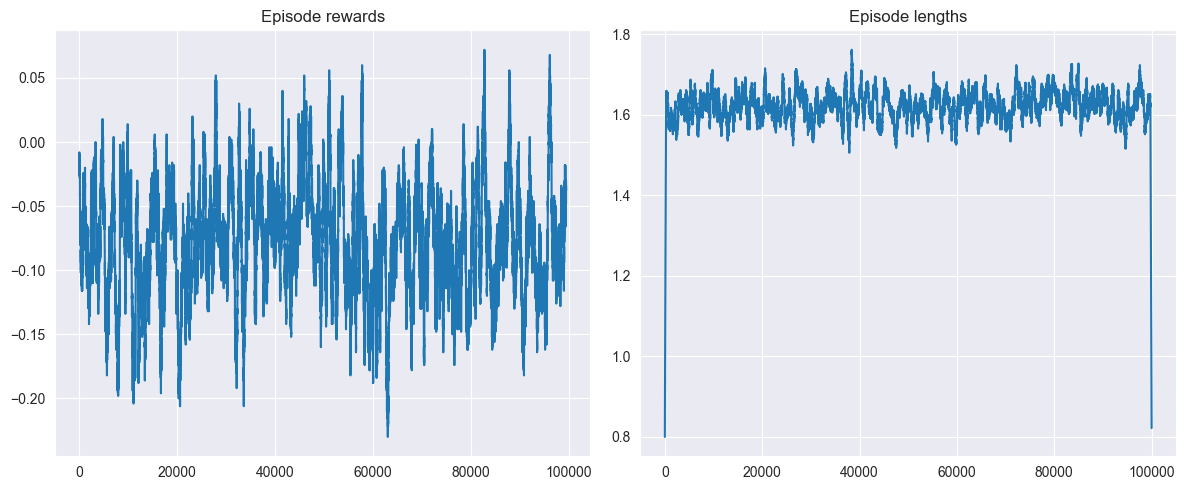

In [18]:
rolling_length = 500
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

In [19]:
win_rate = np.sum(np.array(env.return_queue).flatten() == 1) / len(env.return_queue)
print(win_rate)

0.41079


In [20]:
# simple agent that only takes stick (0)
wins = 0
plays = 1
for i in range(0, plays):
    state, info = env.reset()
    done = False
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        print(state, reward, done)
        if done and reward == 1:
            wins += 1
print(f'Win rate: {wins/plays}')

(29, 5, 0) -1.0 True
Win rate: 0.0
